# Predicting Discharge Reference Capacity using Voltage Rebound Information 

**NOTE**: Using parameters estimated from a logisitic-like function fit on the rebound curve, as well as max measured temp in celsius.

**NOTE**: This analysis does not take into account a cell's cycle history, therefore time is not a predictor and is not considered in this analysis.

**NOTE**: Definitions for logisitc-like estimated parameters:
  
*  L: Asymptotic maximum value  
*  A: Scaling factor  
*  x0: Midpoint of the curve  
*  b: Growth rate  

In [1]:
# load packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data
n9 = pd.read_csv('C:/Users/Worm/Downloads/PartialVRFolder/nasa9.csv')
n10 = pd.read_csv('C:/Users/Worm/Downloads/PartialVRFolder/nasa10.csv')
n11 = pd.read_csv('C:/Users/Worm/Downloads/PartialVRFolder/nasa11.csv')
n12 = pd.read_csv('C:/Users/Worm/Downloads/PartialVRFolder/nasa12.csv')

In [3]:
n_all = pd.concat([n9, n10, n11, n12], axis = 0)

In [4]:
print(n_all.shape)

(942, 7)


In [5]:
n_all.head()

Step         L         A          x0         b  Reference Capacity  \
0   6.0  4.119124  0.045466   40.524623  1.288670         7488.539512   
1   8.0  4.051922  0.051045   42.460846  1.315406         7488.539512   
2  10.0  3.993820  0.058582   52.274587  1.232941         7488.539512   
3  12.0  3.949693  0.073044   85.847404  0.876974         7488.539512   
4  14.0  3.923001  0.104769  208.327442  0.413461         7488.539512   

   Max_Temp  
0  23.77645  
1  23.96379  
2  24.24480  
3  24.54141  
4  24.44775

In [6]:
n_all = n_all.drop(columns = ['Step', 'Max_Temp'])

In [7]:
n_all.isnull().sum()

L                     0
A                     0
x0                    0
b                     0
Reference Capacity    0
dtype: int64

In [8]:
n_all.duplicated().any()

False

In [9]:
n_all.describe()

L           A           x0           b  Reference Capacity
count  942.000000  942.000000   942.000000  942.000000          942.000000
mean     3.842116    0.185566   131.268879    0.793626         5121.015308
std      0.120643    0.099101   545.220556    0.132339         1181.769648
min      3.522871    0.043342    39.092845    0.412259         2764.462952
25%      3.754588    0.108642    72.291702    0.706723         4292.009928
50%      3.798348    0.147816    81.695279    0.781478         4882.550769
75%      3.924442    0.287795    91.248034    0.845787         5921.598421
max      4.119124    0.482510  7691.807163    1.340218         7515.583553

In [10]:
pd.options.display.float_format = '{:.10f}'.format
print(n_all.var())

L                          0.0145546160
A                          0.0098209286
x0                    297265.4543106073
b                          0.0175135419
Reference Capacity   1396579.5014544548
dtype: float64


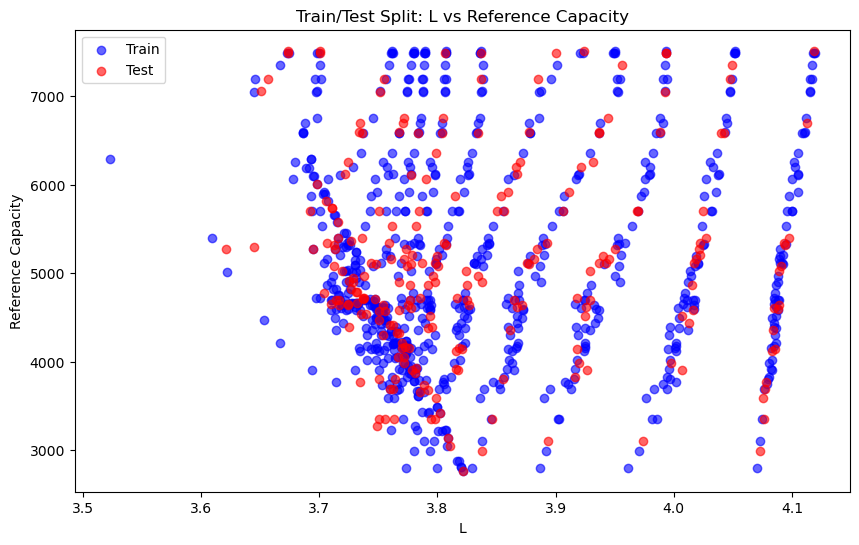

In [11]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define features (X) and target (y)
y = n_all["Reference Capacity"]  # Target
X = n_all.drop('Reference Capacity', axis = 1) # Features

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot training points in blue
plt.scatter(X_train['L'], y_train, color="blue", label="Train", alpha=0.6)

# Plot testing points in red
plt.scatter(X_test['L'], y_test, color="red", label="Test", alpha=0.6)

# Add labels, legend, and title
plt.xlabel("L")
plt.ylabel("Reference Capacity")
plt.title("Train/Test Split: L vs Reference Capacity")
plt.legend()
plt.show()

In [12]:
print(X_train.shape, y_train.shape)
print('\n', X_test.shape, y_test.shape)

(706, 4) (706,)

 (236, 4) (236,)


In [13]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Polynomial Degree 2": Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, X, y):
    rmse_scores = []
    mae_scores = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Evaluate the model
    rmse_scores, mae_scores = evaluate_model(model, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: Linear Regression
  RMSE (folds): [802.0819778268108, 894.4908972231723, 802.0081894809697, 760.192460846115, 793.978555761939]
  MAE (folds): [653.8056391345698, 724.6863311965606, 672.5738023936818, 632.2577289702871, 629.9606989042669]
  Average RMSE: 810.5504
  Average MAE: 662.6568
--------------------------------------------------
Evaluating: Ridge Regression
  RMSE (folds): [801.2034229031879, 894.741285707803, 801.4899270873069, 760.3009342995763, 794.0843287475553]
  MAE (folds): [652.9369751883096, 724.9039268532763, 672.1669723765464, 632.5474283668675, 630.0706269165727]
  Average RMSE: 810.3640
  Average MAE: 662.5252
--------------------------------------------------
Evaluating: Lasso Regression
  RMSE (folds): [801.8116215169462, 894.4968112052846, 801.9805418479446, 760.2210545677339, 793.9700263283706]
  MAE (folds): [653.5822938962305, 724.7081378645453, 672.5496916449014, 632.3063835656833, 629.9701772888758]
  Average RMSE: 810.4960
  Average MAE: 662.62

In [15]:
models.keys()

dict_keys(['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net', 'Polynomial Degree 2'])

In [16]:
models['Elastic Net'].coef_

array([-494.42709076, -850.71429159,   93.5971719 ,  309.32252606])

In [17]:
# x0 most weight in model
# these values might be because of the regularization
# but the features were scaled!

In [18]:
models['Elastic Net'].intercept_

5101.439190825168

In [19]:
X_train_scaled

array([[-1.05246546,  0.42635567, -0.11471568, -0.02661104],
       [-0.82505151, -0.11285327, -0.06126057, -0.57793901],
       [-0.05553334, -1.19537822, -0.14625149,  0.8603845 ],
       ...,
       [ 2.0470858 , -0.90965097, -0.12392011,  1.91875237],
       [ 0.56911012, -0.25856998, -0.09826682, -0.03074085],
       [ 1.31381325, -0.46691603, -0.1015717 , -0.49127091]])

In [20]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Models to evaluate
models = {
    "SVM with RBF Kernel": SVR(kernel='rbf'),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, X, y):
    rmse_scores = []
    mae_scores = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Evaluate the model
    rmse_scores, mae_scores = evaluate_model(model, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: SVM with RBF Kernel
  RMSE (folds): [1264.259501468224, 1205.1368078407538, 1136.783443375599, 1236.8514785322259, 1247.2346296774472]
  MAE (folds): [983.0104215449394, 955.6212237175065, 898.9908339409969, 968.4638398204022, 956.5284918220428]
  Average RMSE: 1218.0532
  Average MAE: 952.5230
--------------------------------------------------
Evaluating: Decision Tree
  RMSE (folds): [377.9684606168543, 404.3396696656261, 384.2096828510703, 364.3246970012546, 414.7665051881739]
  MAE (folds): [258.04226002079315, 257.8612928984206, 257.33101301462636, 236.201990157264, 271.9980479558617]
  Average RMSE: 389.1218
  Average MAE: 256.2869
--------------------------------------------------
Evaluating: Random Forest
  RMSE (folds): [314.2775196925401, 275.23319561636004, 272.5954073101949, 285.05365663953444, 261.38011704332894]
  MAE (folds): [206.75498334371457, 191.51979889684256, 186.98609894398172, 193.9883812199195, 191.367163833652]
  Average RMSE: 281.7080
  Average MA

In [21]:
from sklearn.model_selection import GridSearchCV
import joblib  # To save the model

# Models to evaluate
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Hyperparameter grids
param_grids = {

    "Decision Tree": {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, param_grid, X, y):
    rmse_scores = []
    mae_scores = []
    
    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_  # Get the best model from GridSearchCV
    print(f"Best parameters for {model}: {grid_search.best_params_}")
    
    # Save the best model for Random Forest
    if isinstance(best_model, RandomForestRegressor):
        joblib.dump(best_model, 'best_random_forest_model.joblib')
        print("Best Random Forest model saved as 'best_random_forest_model.joblib'")

    # Save the best model for Decision Tree
    if isinstance(best_model, DecisionTreeRegressor):
        joblib.dump(best_model, 'best_decision_tree_model.joblib')
        print("Best Decision Tree model saved as 'best_decision_tree_model.joblib'")
    
    # Evaluate the best model using cross-validation
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        best_model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = best_model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Get the hyperparameter grid for the model
    param_grid = param_grids[name]
    
    # Evaluate the model with hyperparameter tuning
    rmse_scores, mae_scores = evaluate_model(model, param_grid, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: Decision Tree
Best parameters for DecisionTreeRegressor(random_state=42): {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best Decision Tree model saved as 'best_decision_tree_model.joblib'
  RMSE (folds): [372.67415571814564, 396.25801279204705, 377.63991998915236, 385.038562491018, 367.7247487617255]
  MAE (folds): [258.6005367313003, 273.9933426819969, 247.47920313984866, 262.91763246344533, 247.57794478698736]
  Average RMSE: 379.8671
  Average MAE: 258.1137
--------------------------------------------------
Evaluating: Random Forest
Best parameters for RandomForestRegressor(random_state=42): {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest model saved as 'best_random_forest_model.joblib'
  RMSE (folds): [314.6131304011548, 279.3697912631079, 268.07681575587424, 283.61499722808713, 258.6477693774848]
  MAE (folds): [206.6618520097618, 195.65158272921084, 182.02782563106712, 192.82535015000155, 18

In [22]:
models['Random Forest'].fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [23]:
testpred = models['Random Forest'].predict(X_test_scaled)

In [24]:
import numpy as np

In [25]:
# numbers from previous avg. % diff. values for one cell 4, 8, 11, 31?
# these were transformed by mult. them by 0.10
# then used in np.random.normal for standard devs.
# this creates noisy data and helps to access how robust the model is

In [26]:
# don't have percent diff. values here and just re-used from previous notebook
# then tried new ones based off var. values for features
xnew = X_test*np.random.normal([1,1,1,1], [0.01, 0.01, 0.10, 0.02])

In [27]:
xnew - X_test

L            A            x0             b
101 -0.0154722917 0.0057430779 -2.9416286155 -0.0162505373
123 -0.0155090211 0.0055293131 -2.6683011286 -0.0149032895
158 -0.0157526984 0.0020518254 -2.5726407273 -0.0167183898
138 -0.0155643250 0.0060878833 -3.0542023490 -0.0154153323
30  -0.0157456173 0.0015047087 -2.1222428701 -0.0180708903
..            ...          ...           ...           ...
172 -0.0156294751 0.0062211160 -3.0151973536 -0.0143353659
81  -0.0156124628 0.0023060139 -3.0771623215 -0.0177778130
53  -0.0155246027 0.0029404933 -3.0066348185 -0.0135152681
179 -0.0157947988 0.0028245274 -2.7169975751 -0.0160742091
121 -0.0154683276 0.0053947048 -2.6191783020 -0.0155344022

[236 rows x 4 columns]

In [28]:
xnew = scaler.transform(xnew) # warning bc ran twice on accident

In [29]:
testprednew = models['Random Forest'].predict(xnew)
testprednew

array([4737.59920635, 4443.32069795, 5254.9020319 , 4485.05820425,
       6539.38598376, 5433.92598305, 6683.11724429, 5882.43663203,
       6259.36100963, 5111.61903209, 3255.85047395, 4160.4878159 ,
       4488.73318462, 5724.02692753, 3897.2850799 , 6684.29386478,
       4506.13322178, 4618.09471938, 4472.07606288, 4280.81384301,
       7231.62828851, 3366.65760795, 5892.85122701, 5612.31665225,
       4749.77333208, 5387.43229489, 4380.38945554, 5630.48430639,
       4256.99596399, 5451.28426153, 3826.00547539, 5210.02685035,
       5127.49484881, 5900.59064476, 4361.45355891, 6043.24986985,
       6075.03017993, 4525.35301812, 4171.0338801 , 4260.40201766,
       7492.86940042, 5846.09053021, 4954.30861269, 4212.47600387,
       3792.67728904, 5753.73990067, 7119.45795413, 4451.25193568,
       5937.85645914, 6478.42289564, 6077.52654172, 4745.30921994,
       5497.87034827, 4623.1071279 , 6080.73135613, 4439.30327464,
       7321.62668462, 3869.26522455, 4339.37348476, 6311.97985

In [30]:
testpred

array([4624.8370933 , 4594.13123431, 5181.01856189, 4301.60036781,
       6380.65624673, 4580.24755406, 6807.08556512, 6003.56910533,
       6625.36793327, 4960.00277699, 3229.25016749, 4186.87403118,
       4553.07697099, 5095.28791687, 3942.09244421, 6707.07048001,
       4510.42837541, 4480.65272071, 4558.69781827, 4452.02722862,
       7289.88865557, 3181.23331287, 5245.80739308, 4963.25011242,
       4828.81809116, 5280.60470191, 4041.65589626, 4866.77811793,
       4332.43932289, 5702.25850289, 4194.74431543, 5122.00640265,
       4750.55703966, 5974.25441666, 4429.12012434, 6074.7336621 ,
       5939.92361874, 4315.13470393, 4009.49730859, 4335.67445785,
       7495.71254043, 5369.99456904, 5057.76076937, 4071.10825421,
       3891.4380043 , 5138.64391823, 7137.31501814, 4198.174296  ,
       6145.44935543, 6427.81076451, 5835.71911514, 4610.67747472,
       5201.05734285, 5248.75090355, 6037.69672584, 4073.59496579,
       7488.01390664, 4156.96446693, 4588.76585536, 6220.70339

In [31]:
from sklearn.metrics import mean_absolute_percentage_error

In [32]:
mean_absolute_percentage_error(testpred, testprednew)

0.0415025101172745

DecisionTreeRegressor(random_state=42) 382.15264546392586
RandomForestRegressor(random_state=42) 282.38219373475147
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...) 290.19368934682456


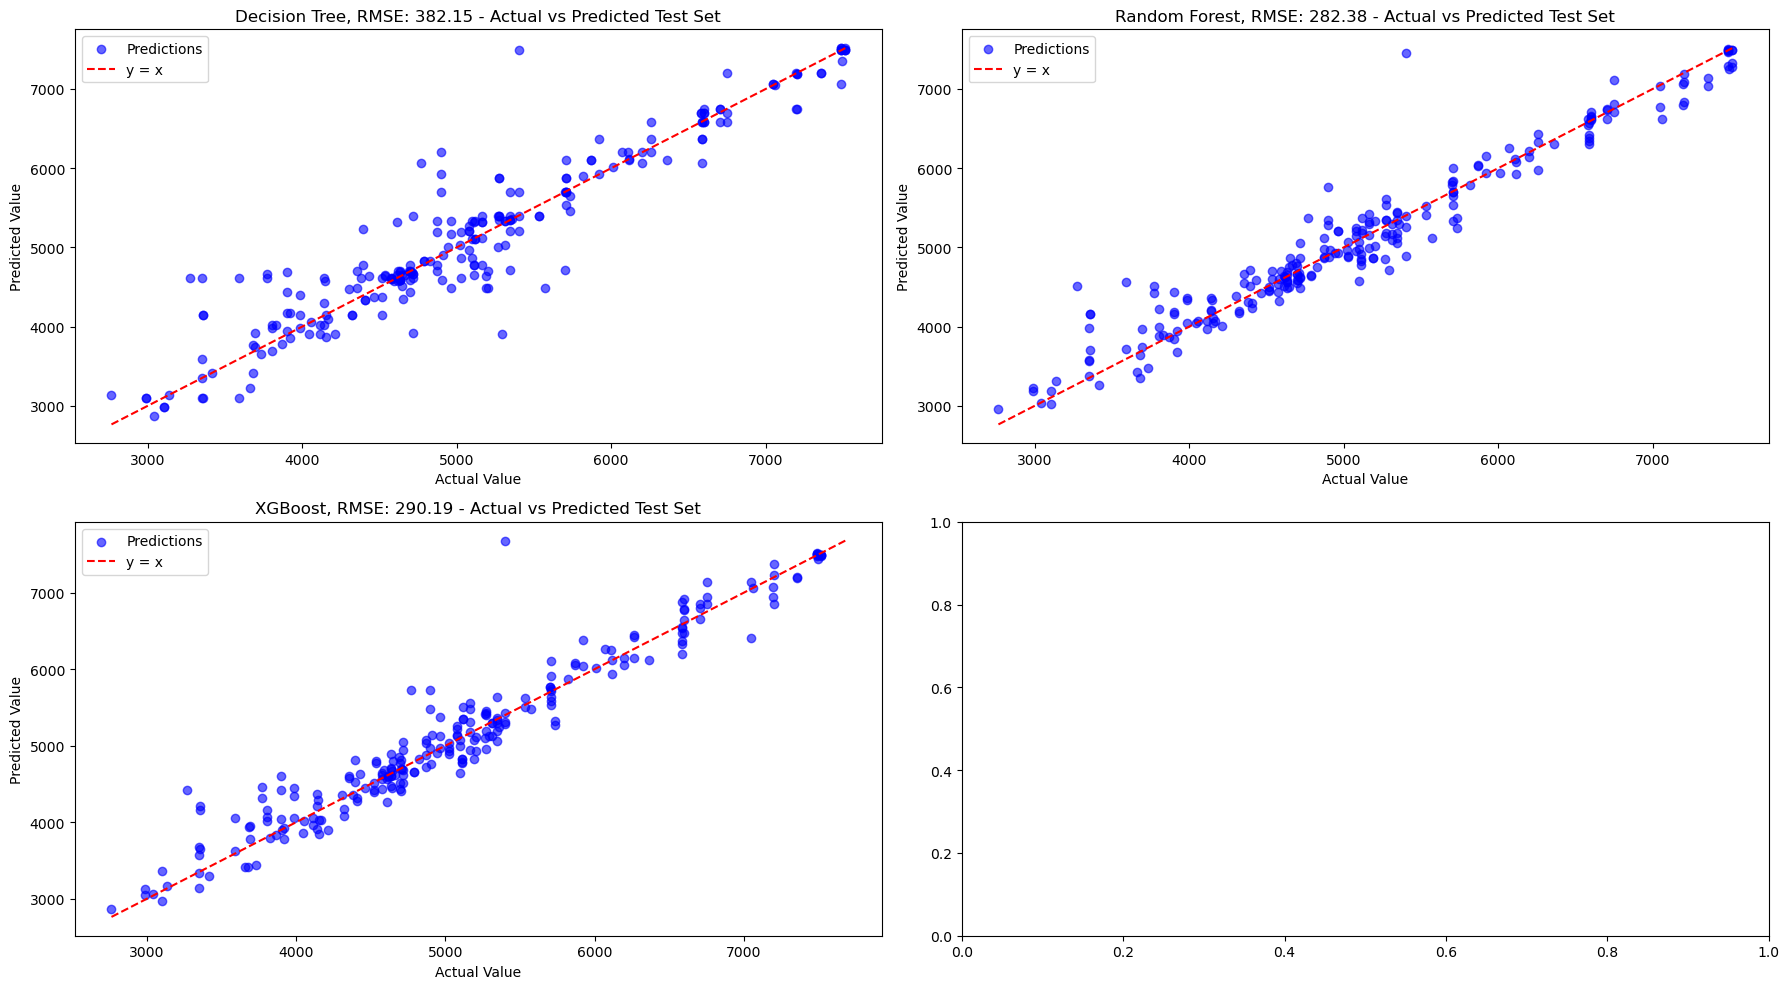

In [33]:
# Define the feature names
features = ['L', 'A', 'x0', 'b']

# Create a subplot grid (1x2)
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Flatten axes array for easier indexing
axes = axes.flatten()

# List to store RMSE values for each model
rmse_values = []

# Convert y_test to numpy for plotting
y_test_np = y_test.to_numpy()

# Fit each model, extract coefficients, and plot
for i, (name, model) in enumerate(models.items()):
    # Fit the model
    model.fit(X_train_scaled, y_train_np)
    
    # Calculate RMSE for the current model
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    rmse_values.append(rmse)

    print(model, rmse)

    # Plot Actual vs Predicted
    axes[i].scatter(y_test_np, y_pred, label='Predictions', color='blue', alpha=0.6)
    
    # Plot the "actual = predicted" line (y = x line)
    min_val = min(np.min(y_test_np), np.min(y_pred))
    max_val = max(np.max(y_test_np), np.max(y_pred))
    axes[i].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="y = x")
    
    # Set titles and labels
    axes[i].set_title(f'{name}, RMSE: {rmse.round(2)} - Actual vs Predicted Test Set')
    axes[i].set_xlabel('Actual Value')
    axes[i].set_ylabel('Predicted Value')
    axes[i].legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

Decision Tree:
  MSE: 146040.64
  MAE: 232.75

Random Forest:
  MSE: 79739.70
  MAE: 180.48

XGBoost:
  MSE: 84212.38
  MAE: 187.47



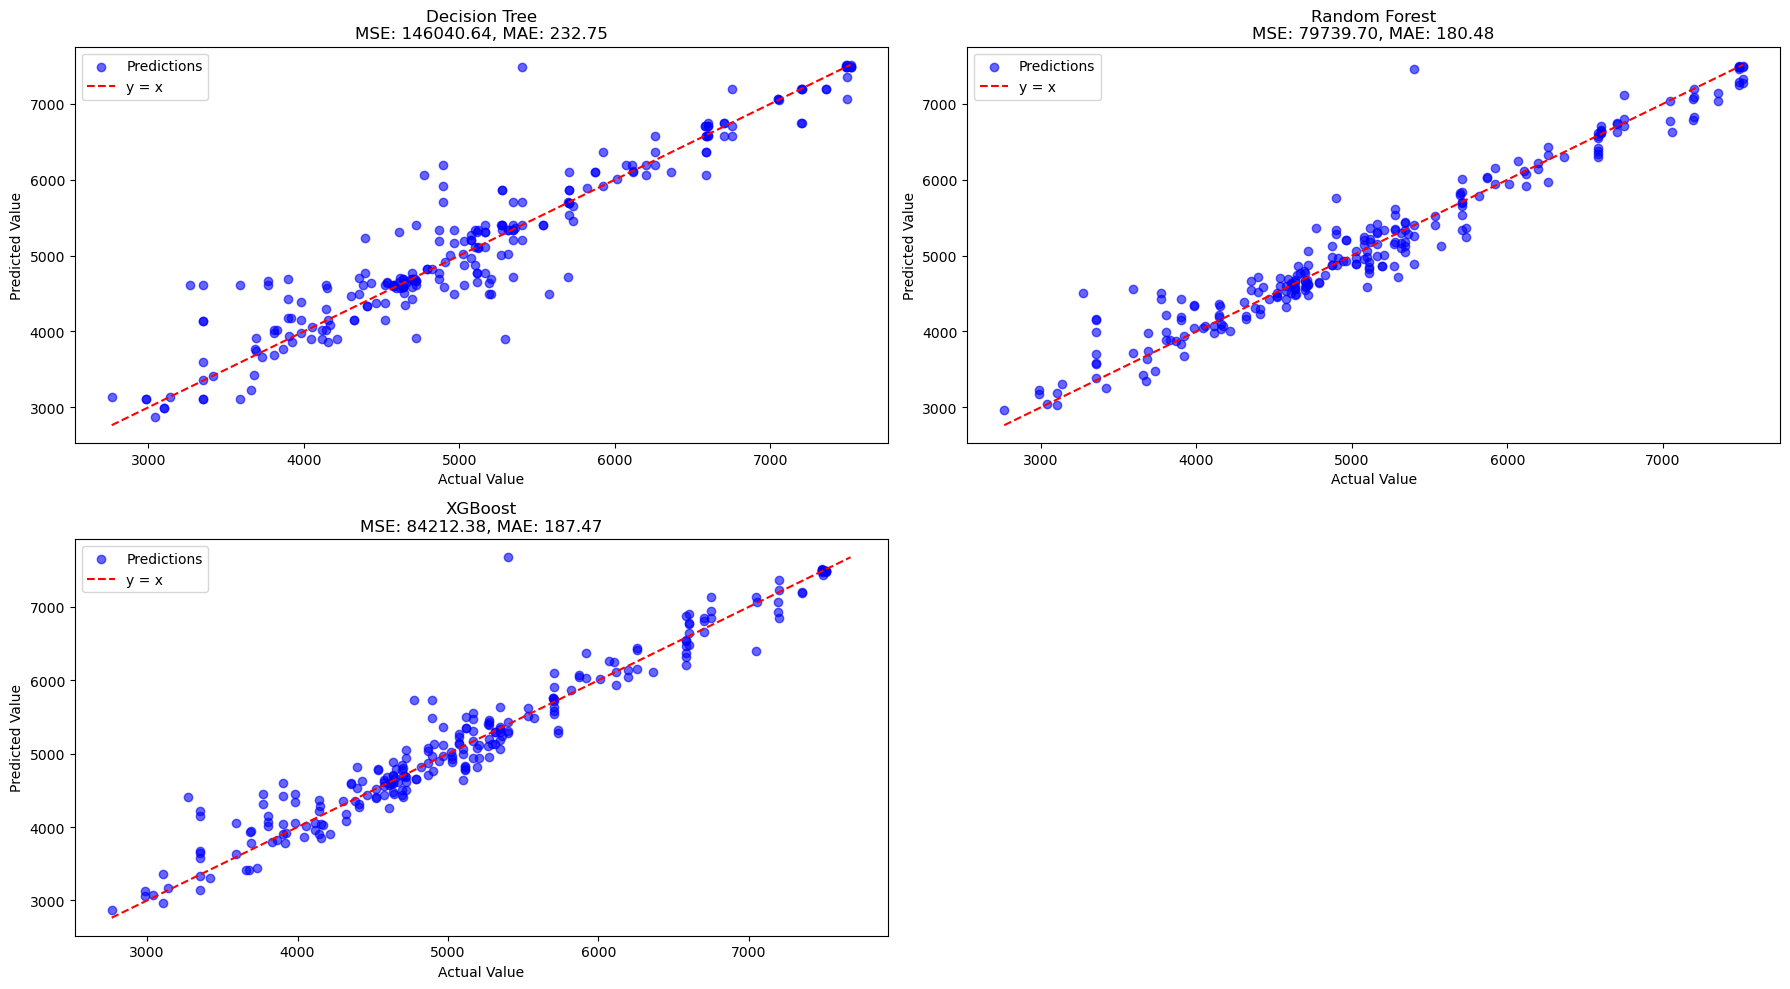

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Make sure these exist in your session:
# y_test, y_train_np, X_train_scaled, X_test_scaled, models

# Convert y_test to numpy
y_test_np = y_test.to_numpy()

# Lists to store metrics
mse_values = []
mae_values = []

# Determine number of models
n_models = len(models)
n_cols = 2
n_rows = math.ceil(n_models / n_cols)

# Create subplots dynamically
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

# Loop through models
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train_scaled, y_train_np)
    y_pred = model.predict(X_test_scaled)

    # Compute metrics
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)

    mse_values.append(mse)
    mae_values.append(mae)

    print(f"{name}:")
    print(f"  MSE: {mse:.2f}")
    print(f"  MAE: {mae:.2f}\n")

    # Plot actual vs predicted
    ax = axes[i]
    ax.scatter(y_test_np, y_pred, label='Predictions', color='blue', alpha=0.6)
    min_val = min(np.min(y_test_np), np.min(y_pred))
    max_val = max(np.max(y_test_np), np.max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

    # Update plot with MSE and MAE
    ax.set_title(f'{name}\nMSE: {mse:.2f}, MAE: {mae:.2f}')
    ax.set_xlabel('Actual Value')
    ax.set_ylabel('Predicted Value')
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [35]:
# List to store percentage RMSE values
percent_rmse_values = {}

# Convert y_test to numpy for easier handling
y_test_np = y_test.to_numpy()

# Evaluate each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train_np)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    
    # Calculate percentage RMSE
    mean_actual = np.mean(y_test_np)
    percent_rmse = (rmse / mean_actual) * 100
    
    # Store the percentage RMSE
    percent_rmse_values[name] = percent_rmse

# Print out the percentage RMSE for each model
for name, percent_rmse in percent_rmse_values.items():
    print(f"{name} - Percentage RMSE: {percent_rmse:.2f}%")

Decision Tree - Percentage RMSE: 7.48%
Random Forest - Percentage RMSE: 5.53%
XGBoost - Percentage RMSE: 5.68%


In [36]:
# new for mse and mae for prez
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Dictionaries to store metrics
percent_rmse_values = {}
mse_values = {}
mae_values = {}

y_test_np = y_test.to_numpy()

for name, model in models.items():
    model.fit(X_train_scaled, y_train_np)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test_np, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_np, y_pred)
    mean_actual = np.mean(y_test_np)
    percent_rmse = (rmse / mean_actual) * 100

    # Store
    percent_rmse_values[name] = percent_rmse
    mse_values[name] = mse
    mae_values[name] = mae

# Print summary
for name in models.keys():
    print(f"{name}:")
    print(f"  %RMSE: {percent_rmse_values[name]:.2f}%")
    print(f"  MSE:   {mse_values[name]:.2f}")
    print(f"  MAE:   {mae_values[name]:.2f}\n")


Decision Tree:
  %RMSE: 7.48%
  MSE:   146040.64
  MAE:   232.75

Random Forest:
  %RMSE: 5.53%
  MSE:   79739.70
  MAE:   180.48

XGBoost:
  %RMSE: 5.68%
  MSE:   84212.38
  MAE:   187.47



In [37]:
features

['L', 'A', 'x0', 'b']

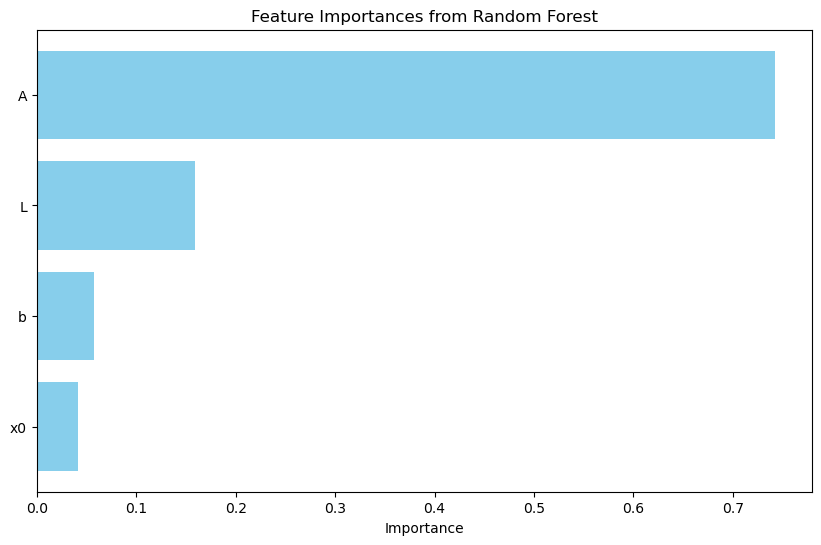

In [38]:
best_model = joblib.load('best_random_forest_model.joblib')

# Get feature importances from the model
importances = best_model.feature_importances_

# Create a DataFrame for better visualization (optional, but can make it easier to view)
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the importances by value
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.savefig('random_forest_nasa.png')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()

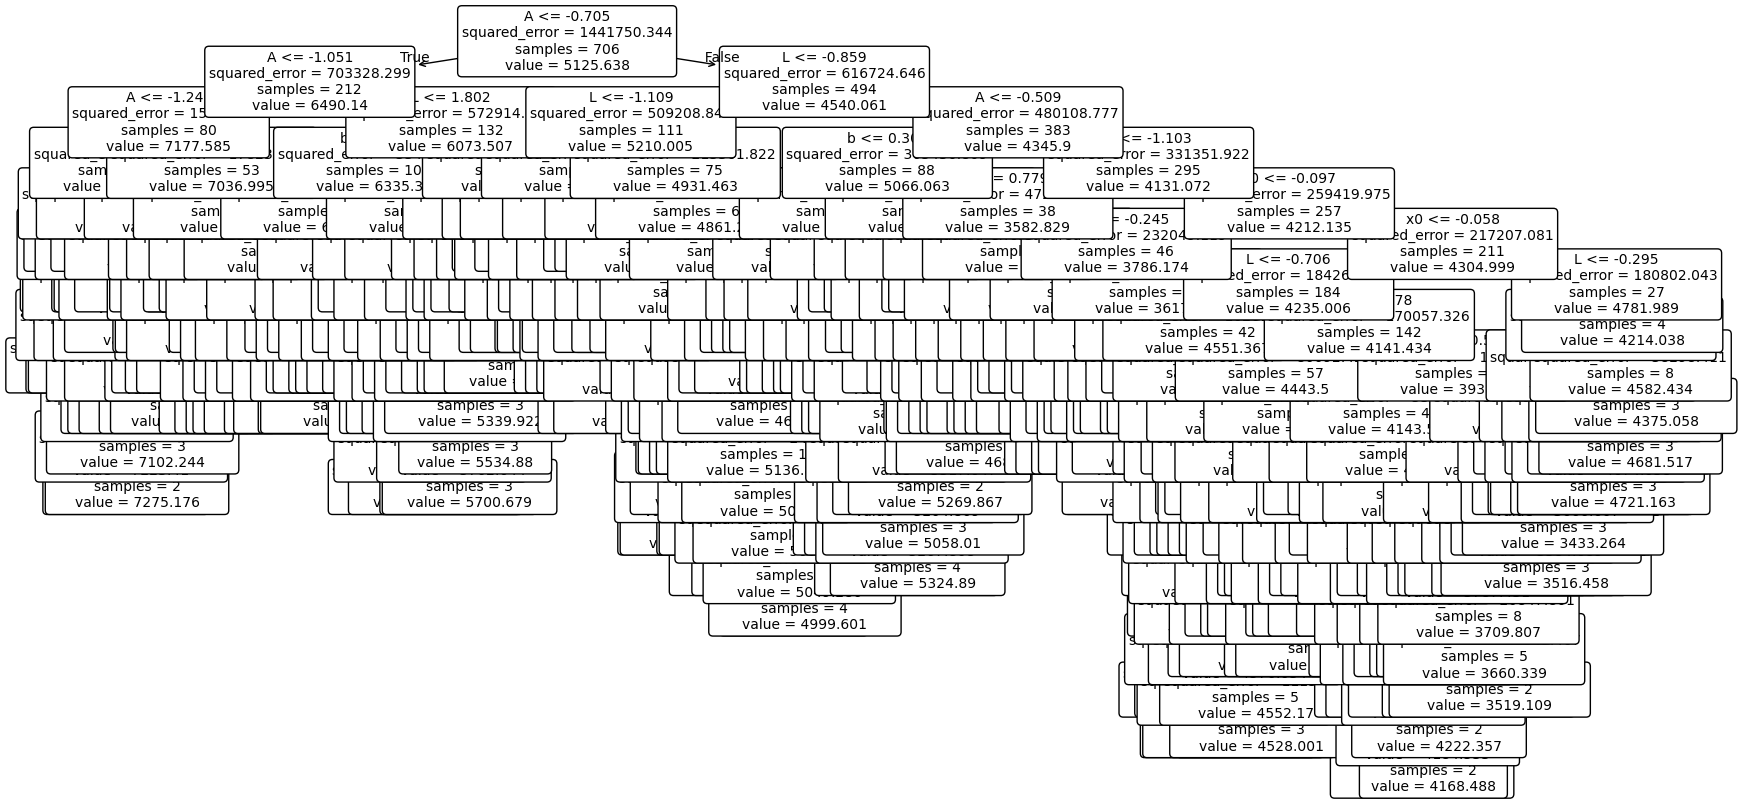

In [39]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Load the model
best_model = joblib.load('best_decision_tree_model.joblib')

# Plot the tree
plt.figure(figsize=(20, 10))  # Adjust the size as needed
plot_tree(best_model, 
          feature_names=features,  # Replace with your feature names
          # class_names=['class1', 'class2'],  # Replace with your class names if classification
          filled=False, 
          rounded=True, 
          fontsize=10)
plt.show()

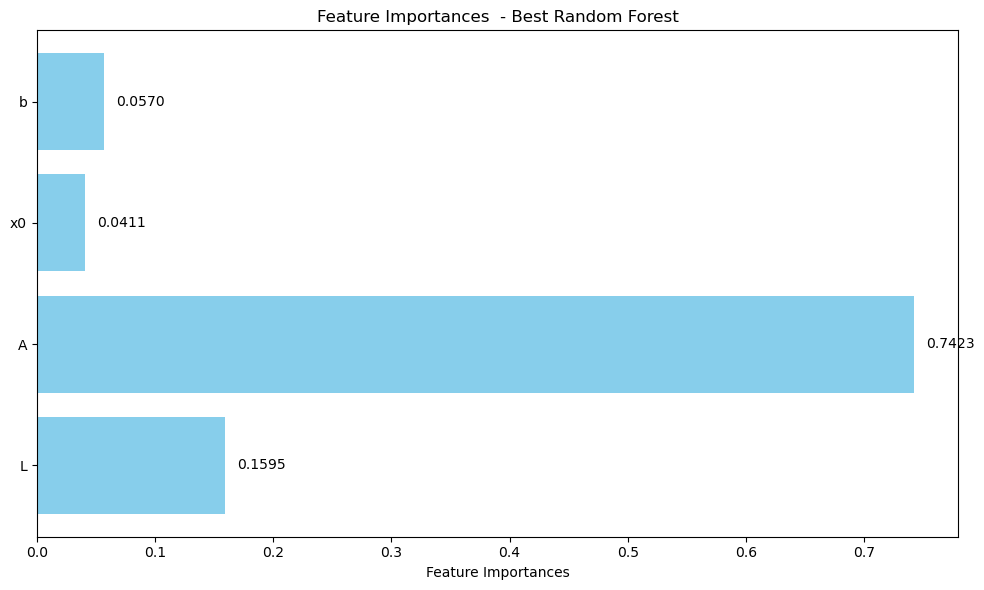

In [40]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importances')
plt.title('Feature Importances  - Best Random Forest')

# Annotate the plot with the actual coefficients
for i, (coef, feature) in enumerate(zip(importances, features)):
    plt.text(importances[i] + 0.01, i, f'{coef:.4f}', va='center')

plt.tight_layout()
plt.show()